In [12]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

In [9]:
MODEL_PATH = "/Users/skku_aws19/Desktop/aws_project/AWS-SAY-1-Team4/pneumo-ai-pipeline/results-aws-say1-4team-2025-07-20-15-18-09-2025-07-20-06-18-09-045/model.pth"
NUM_CLASSES = 3
BATCH_SIZE = 32
DATA_DIR = "/Users/skku_aws19/Desktop/aws_project/AWS-SAY-1-Team4/pneumo-ai-pipeline/data/preprocessed/test"    # test 이미지 폴더
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [5]:
test_dataset = datasets.ImageFolder(DATA_DIR, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [6]:
model = models.resnet50(weights=None)  # pretrained는 False로 두고 직접 로드
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
confidences = []
corrects = []

In [8]:
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        conf, preds = probs.max(dim=1)
        correct = preds.eq(labels).float()

        confidences.extend(conf.cpu().numpy())
        corrects.extend(correct.cpu().numpy())

In [9]:
confidences = np.array(confidences)
corrects = np.array(corrects)
bins = np.linspace(0, 1, 11)  # 0.0 ~ 1.0 구간을 10개로 나눔
bin_acc = []
bin_count = []

for i in range(len(bins) - 1):
    bin_mask = (confidences >= bins[i]) & (confidences < bins[i + 1])
    if bin_mask.sum() > 0:
        bin_acc.append(corrects[bin_mask].mean())
        bin_count.append(bin_mask.sum())
    else:
        bin_acc.append(0)
        bin_count.append(0)

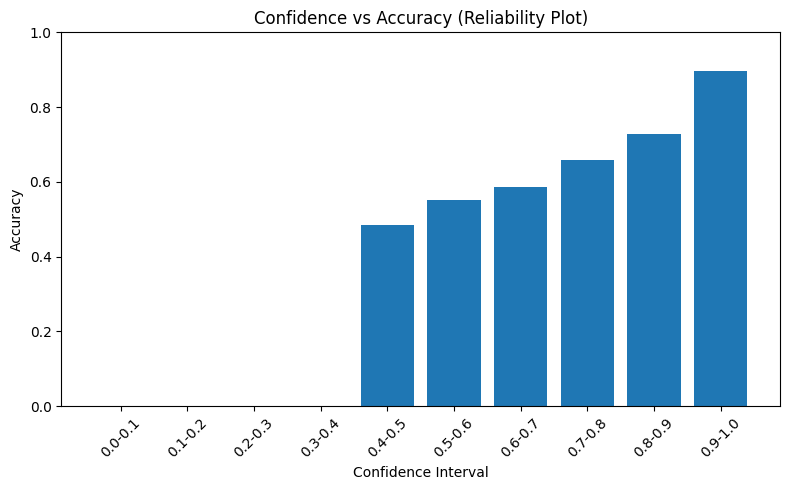

In [10]:
plt.figure(figsize=(8,5))
x_labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]
plt.bar(x_labels, bin_acc)
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.xlabel("Confidence Interval")
plt.ylabel("Accuracy")
plt.title("Confidence vs Accuracy (Reliability Plot)")
plt.tight_layout()
plt.show()


In [15]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict

def confidence_distribution(model, test_loader, device, bins=None, visualize=True):
    model.eval()
    model.to(device)

    # 기본 구간: 0.1 단위로 나눔 (총 10개)
    if bins is None:
        bins = [round(x * 0.1, 1) for x in range(11)]  # [0.0, 0.1, ..., 1.0]

    bin_labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]
    bin_counts = defaultdict(int)

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            max_conf, _ = torch.max(probs, dim=1)

            for conf in max_conf.cpu().numpy():
                for i in range(len(bins) - 1):
                    # 마지막 구간 포함: [0.9, 1.0]
                    if (bins[i] <= conf < bins[i + 1]) or (i == len(bins) - 2 and conf == 1.0):
                        bin_counts[bin_labels[i]] += 1
                        break

    # 출력
    for k in bin_labels:
        print(f"{k}: {bin_counts[k]} images")

    # 시각화
    if visualize:
        plt.bar(bin_labels, [bin_counts[k] for k in bin_labels])
        plt.xlabel("Confidence Interval")
        plt.ylabel("Number of Images")
        plt.title("Distribution of Confidence Scores (0.1 bins)")
        plt.grid(True, axis='y')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return bin_counts


0.0-0.1: 0 images
0.1-0.2: 0 images
0.2-0.3: 0 images
0.3-0.4: 2 images
0.4-0.5: 31 images
0.5-0.6: 316 images
0.6-0.7: 350 images
0.7-0.8: 398 images
0.8-0.9: 572 images
0.9-1.0: 1596 images


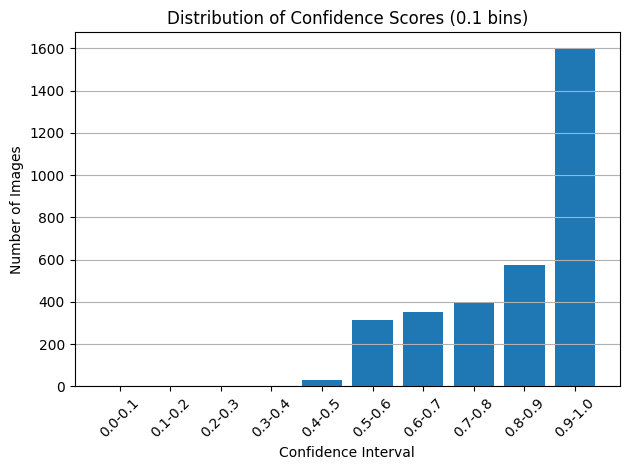

defaultdict(int,
            {'0.9-1.0': 1596,
             '0.8-0.9': 572,
             '0.7-0.8': 398,
             '0.5-0.6': 316,
             '0.6-0.7': 350,
             '0.4-0.5': 31,
             '0.3-0.4': 2,
             '0.0-0.1': 0,
             '0.1-0.2': 0,
             '0.2-0.3': 0})

In [16]:
confidence_distribution(model, test_loader, DEVICE)

In [17]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

def confidence_distribution(model, test_loader, device, bins=None, visualize=True):
    model.eval()
    model.to(device)

    # 기본 구간: 0.05 단위로 나눔 (총 20개)
    if bins is None:
        bins = np.arange(0.0, 1.05, 0.05).tolist()  # [0.0, 0.05, ..., 1.0]

    bin_labels = [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins)-1)]
    bin_counts = defaultdict(int)

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            max_conf, _ = torch.max(probs, dim=1)

            for conf in max_conf.cpu().numpy():
                for i in range(len(bins) - 1):
                    # 마지막 구간 포함 (1.0 포함)
                    if (bins[i] <= conf < bins[i + 1]) or (i == len(bins) - 2 and conf == 1.0):
                        bin_counts[bin_labels[i]] += 1
                        break

    # 출력
    for k in bin_labels:
        print(f"{k}: {bin_counts[k]} images")

    # 시각화
    if visualize:
        plt.bar(bin_labels, [bin_counts[k] for k in bin_labels])
        plt.xlabel("Confidence Interval")
        plt.ylabel("Number of Images")
        plt.title("Distribution of Confidence Scores (0.05 bins)")
        plt.grid(True, axis='y')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

    return bin_counts

0.00-0.05: 0 images
0.05-0.10: 0 images
0.10-0.15: 0 images
0.15-0.20: 0 images
0.20-0.25: 0 images
0.25-0.30: 0 images
0.30-0.35: 0 images
0.35-0.40: 2 images
0.40-0.45: 7 images
0.45-0.50: 24 images
0.50-0.55: 145 images
0.55-0.60: 171 images
0.60-0.65: 179 images
0.65-0.70: 171 images
0.70-0.75: 199 images
0.75-0.80: 199 images
0.80-0.85: 274 images
0.85-0.90: 298 images
0.90-0.95: 435 images
0.95-1.00: 1161 images


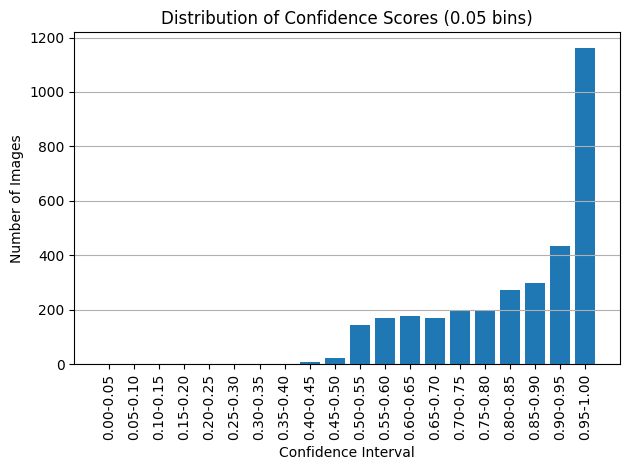

defaultdict(int,
            {'0.95-1.00': 1161,
             '0.90-0.95': 435,
             '0.80-0.85': 274,
             '0.75-0.80': 199,
             '0.85-0.90': 298,
             '0.70-0.75': 199,
             '0.55-0.60': 171,
             '0.65-0.70': 171,
             '0.60-0.65': 179,
             '0.50-0.55': 145,
             '0.40-0.45': 7,
             '0.45-0.50': 24,
             '0.35-0.40': 2,
             '0.00-0.05': 0,
             '0.05-0.10': 0,
             '0.10-0.15': 0,
             '0.15-0.20': 0,
             '0.20-0.25': 0,
             '0.25-0.30': 0,
             '0.30-0.35': 0})

In [18]:
confidence_distribution(model, test_loader, DEVICE)

In [7]:
import torch
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms
from tqdm import tqdm

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "/Users/skku_aws19/Desktop/aws_project/AWS-SAY-1-Team4/pneumo-ai-pipeline/results-aws-say1-4team-2025-07-29-13-02-16-2025-07-29-04-02-16-778/model.pth"
confidence_threshold = 0.65

In [16]:
model = models.resnet50(pretrained=False)  # ✅ 깔끔하게 pretrained 제거
model.fc = torch.nn.Linear(model.fc.in_features, 3)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

/Users/skku_aws19/Desktop/aws_project/AWS-SAY-1-Team4/pneumo-ai-pipeline/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/skku_aws19/Desktop/aws_project/AWS-SAY-1-Team4/pneumo-ai-pipeline/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [18]:
from torchvision import datasets
test_dataset = datasets.ImageFolder(DATA_DIR, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [20]:
image_paths = [path for path, _ in test_loader.dataset.samples]

# 2. low confidence 결과 저장
low_confidence_images = []

# 3. 모델 추론
idx = 0  # image index

with torch.no_grad():
    for images, _ in tqdm(test_loader):
        images = images.to(device)
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        max_probs, _ = torch.max(probs, dim=1)

        for prob in max_probs:
            if prob.item() <= confidence_threshold:
                file_path = image_paths[idx]
                file_name = os.path.basename(file_path)  # 경로가 아닌 파일 이름만
                low_confidence_images.append((file_name, prob.item()))
            idx += 1

# 4. 결과 출력
print(f"\n총 {len(low_confidence_images)}개의 이미지가 confidence ≤ {confidence_threshold} 조건을 만족합니다.")
for path, conf in low_confidence_images:
    print(f"{path} -> confidence: {conf:.4f}")

# 5. CSV 저장
pd.DataFrame(low_confidence_images, columns=["Image", "Confidence"]).to_csv("low_confidence_images.csv", index=False)

100%|██████████| 103/103 [04:18<00:00,  2.51s/it]


총 903개의 이미지가 confidence ≤ 0.65 조건을 만족합니다.
00000372_014.png -> confidence: 0.4532
00000502_014.png -> confidence: 0.4845
00003305_000.png -> confidence: 0.6070
00004186_000.png -> confidence: 0.3620
00004893_028.png -> confidence: 0.5081
00004911_007.png -> confidence: 0.5164
00005539_010.png -> confidence: 0.4887
00005609_026.png -> confidence: 0.4466
00006450_005.png -> confidence: 0.6394
00006507_001.png -> confidence: 0.6011
00007453_002.png -> confidence: 0.5685
00007914_002.png -> confidence: 0.5147
00008708_010.png -> confidence: 0.4673
00013346_011.png -> confidence: 0.5587
00013890_003.png -> confidence: 0.6298
00014387_013.png -> confidence: 0.5666
00018224_002.png -> confidence: 0.6313
00019021_004.png -> confidence: 0.6037
00019124_037.png -> confidence: 0.6141
00019396_000.png -> confidence: 0.5919
00019449_001.png -> confidence: 0.5022
00023129_000.png -> confidence: 0.5297
00025075_000.png -> confidence: 0.5593
00026114_000.png -> confidence: 0.3722
00027930_000.png -> c